# Using scikit-learn classification to filter out badly segmented cells

In this notebook we are going to train a classifier to automatically filter out badly segmented cells using morphological measurements.   
We will be covering:
1. Instance segmentation from a binary image
2. Measuring morphological features
3. Training a classifier on manually annotated data of well and badly segmented cells
4. Filter out badly segmented cells using the trained classifier

## 1. Let's start by installing all required libraries

In [1]:
!pip install numpy scipy scikit_image scikit_learn matplotlib pandas -q

## 2. Performing instance segmentation from a binary image using scikit-image
Similarly to day 2 exercises we will perform instance segmentation from a binary image.  

---

For that we will start by loading the phase contrast image (`../data/images/wt_phase_contrast.tif`) and the binary mask image (`../data/images/wt_mask.tif`):   

Let's load the images seperately and show them with `matplotlib` using `subplots`.

Step-by-step: 
1. import the `skimage` module to load images
    - _hint_: such as done earlier using `imread`
1. load each image into a separate variable
1. display each image as a subplot using `matplotlib`

--- 
```python
from skimage.io import imread
phase = imread("path/to/phase_contrast")
mask = imread("path/to/binary_mask")
```  

---
Let's use matplotlib to display it:   
```python
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5)) # set the figure size
plt.subplot(1, 2, 1) # create a subplot on a 1x2 grid
plt.title('Phase Constrast') # set the title
plt.imshow(phase, cmap='gray') # display the image
plt.axis('off') # turn off the axis

# do the same for the second subplot. hint: use plt.subplot(1, 2, 2)
```

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

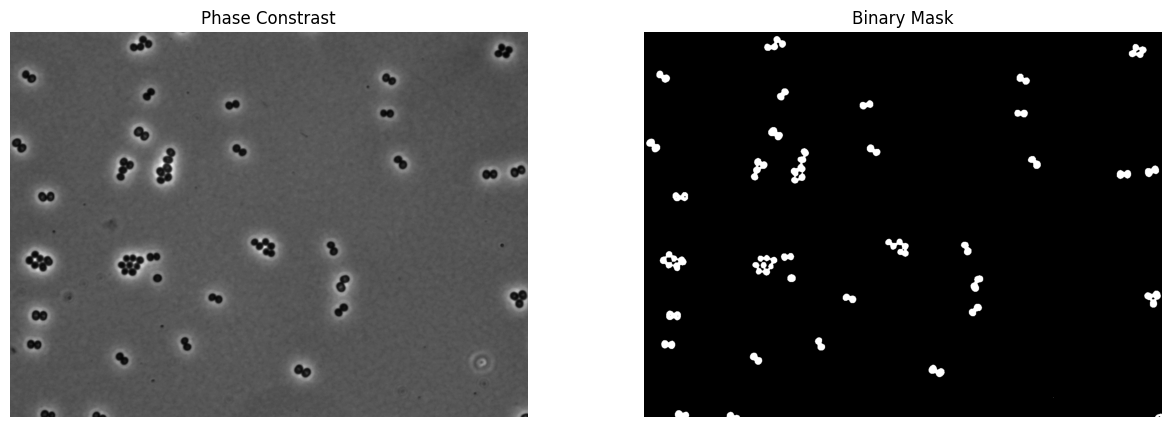

In [2]:
# your code here
from skimage.io import imread
from matplotlib import pyplot as plt

phase = imread("../data/images/wt_phase_contrast.tif")
mask = imread("../data/images/wt_mask.tif")

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Phase Constrast')
plt.imshow(phase, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Binary Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

## 3. Performing the instance segmentation

Some cells have an opening in the binary mask, we can fill it using scipy [`binary_fill_holes`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_fill_holes.html) from the [`ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html) module.   
```python
from scipy.ndimage import binary_fill_holes
filled_mask = binary_fill_holes(mask)
```
   
Display the result using `matplotlib` `imshow` function.


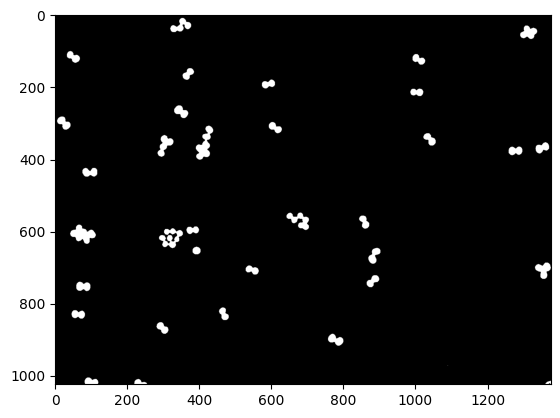

In [3]:
# your code here
from scipy import ndimage as ndi
filled_mask = ndi.binary_fill_holes(mask)
plt.imshow(filled_mask, cmap="gray")

We have touching cells forming a much larger mask  which does not accurately represent the cell.
So, we want to split the masks to get individual cells. We will be using the `watershed` algorithm to split masks.

The `watershed` algorithm needs additional information before splitting the masks. It needs markers (also known as seeds) to define the center of the cell masks, and a distance map which creates an image of the distance of each pixel to the mask border.

First, let's start by creating a distance map.  

--- 

For this we can use `scipy` distance transform from the [ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) module.

```python
from scipy.ndimage import distance_transform_edt
distances = distance_transform_edt(filled_mask)
```
   
Display the result using matplotlib imshow function.

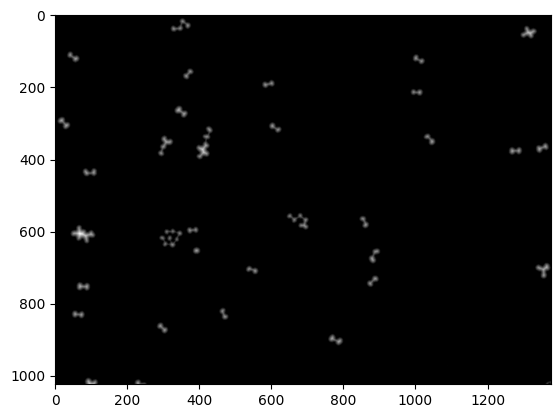

In [4]:
# your code here
from scipy.ndimage import distance_transform_edt
distances = distance_transform_edt(filled_mask)
plt.imshow(distances, cmap="gray")

Then, we need to create an image with only the markers. We will use the local maxima of the distance map to get an approximate center of the cells.

For this we can use scikit-image [`peak_local_max`](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.peak_local_max) from the [`skimage.feature`](https://scikit-image.org/docs/stable/api/skimage.feature.html) module to get a list of coordinated for the local maxima.

However, since we only get a list of coordinates, we need to create an image with only the local maxima.
Then we will create an empty image using `numpy` `zero_like` function and assign a value of `True` to each local maxima.   

---
And finally we will add individual labels for each local maxima using the [label](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html#scipy.ndimage.label) function from `scipy.ndimage` module.

```python
import numpy as np
from skimage.feature import peak_local_max
from scipy.ndimage import label
coordinates = peak_local_max(distances, labels=filled_mask) # extract the local maxima coordinates
coordinates_tuple = tuple(coordinates.T) # convert the coordinates to a tuple to allow numpy array indexing
local_maxima = np.zeros_like(filled_mask, dtype=bool) # create an empty image
local_maxima[coordinates_tuple] = True # assign a value of True to the local maxima
markers = label(local_maxima)[0] # add individual label (ID) for each local maxima
```

Step-by-step:
1. from the distance transform image, get a list of local maxima
1. create an empty image with the same shape as the original
1. assign a value of `True` to the pixel coordinates in the local maxima
1. add an individual label to each marker

In [5]:
# your code here
import numpy as np
from skimage.feature import peak_local_max
from scipy.ndimage import label
coordinates = peak_local_max(distances, labels=filled_mask)
coordinates_tuple = tuple(coordinates.T)
local_maxima = np.zeros_like(filled_mask, dtype=bool)
local_maxima[coordinates_tuple] = True
markers = label(local_maxima)[0]

Now we can apply the [`watershed`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) algorithm from scikit-image.   

_Note_: for historical reasons, the `watershed` expects darker intensity values as the objects, so we need to invert the distance map. 

```python
labels = watershed(-distance_map, markers, mask=filled_mask) # we need to use the inverted distance transform
```

---
To better visualize if the `watershed` did a good job, we will assign random colors to each cell mask (for display purposes only), [`label2rgb`](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.label2rgb) function from the `color` module of scikit-image does the trick.

---

```python
from skimage.color import label2rgb
colored_labels = label2rgb(labels, bg_label=0)
```

---

Use the `matplotlib` `imshow` function to display the overlay as well as a cropped version of the overlay.
Use indexes [200:500, 200:600] to zoom in.
```python
plt.imshow(colored_labels[200:500, 200:600], cmap='gray')
```

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

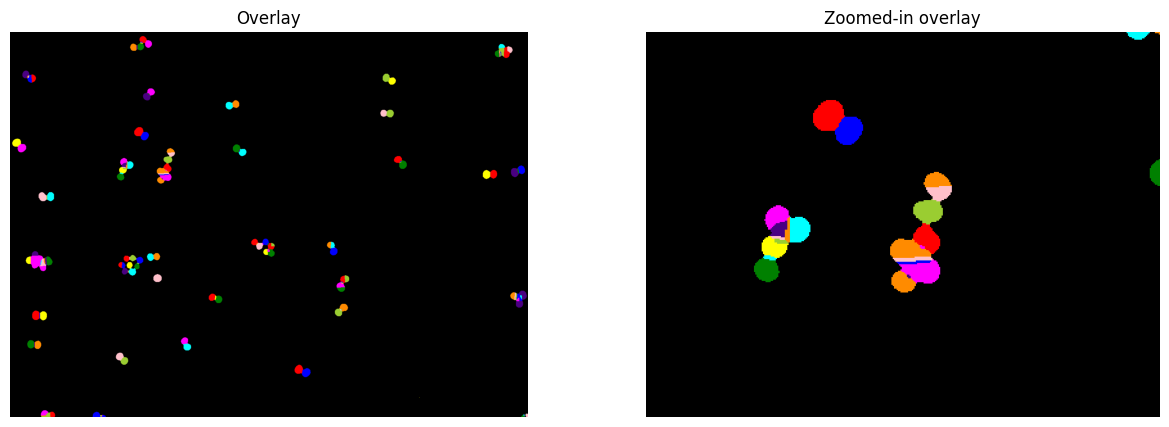

In [6]:
# now we run the watershed algorithm
from skimage.segmentation import watershed
labels = watershed(-distances, markers, mask=filled_mask)

from skimage.color import label2rgb
colored_labels = label2rgb(labels, bg_label=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Overlay')
plt.imshow(colored_labels, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Zoomed-in overlay")
plt.imshow(colored_labels[200:500, 200:600], cmap='gray')
plt.axis('off')

## 4. Filtering out badly segmented cells using a classification algorithm
As you can see in the zoomed in colored image, some cells are not properly segmented.  
We will try to train a classifier to automatically classify well and badly segmented cells and then filter out badly segmented cells.  

---

The data in the `segmentation_quality.csv` file contains morphological measurements of segmented cells with an extra column of manual annotations "Well Segmented":   
- 0 = badly segmented
- 1 = well segmented

---

Start by taking a look at the data by reading it using `pandas`.   
```python
import pandas as pd
data = pd.read_csv("../data/segmentation_quality.csv")
data.head()
```

In [7]:
# your code here
import pandas as pd
data = pd.read_csv("../data/segmentation_quality.csv")
data.head()

,Cell ID,Area,Perimeter,Length,Width,Eccentricity,Well Segmented
0,1,209,71,18.601075,15.000000,0.591364,1
1,2,224,79,19.416488,15.811388,0.580405,1
2,3,263,87,24.166092,15.652476,0.761892,1
3,4,204,76,25.455844,12.041595,0.881042,1
4,5,229,81,20.615528,15.524175,0.657983,1


As we did in Notebook #2, we need to shuffle and standardize the data. Feel free to look at step 5 of that notebook and reuse the code.

In [8]:
# your code here
def normalize_column(data_column):

    mean = data_column.mean()

    std = data_column.std()

    normalized_column = (data_column - mean) / std

    return normalized_column

normalized_data = data.copy()
cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity']

for col in cols:
    normalized_data[col] = normalize_column(data[col])

## 5. Train a `LogisticRegression` classifier to automatically classify well and badly segmented 
Look at how you solved the classification problem in the previous notebook to complete the next steps:


a) Shuffle and separate the data both into training and testing datasets

In [10]:
# your code here
normalized_data = normalized_data.sample(frac=1).reset_index(drop=True)

rows, cols = normalized_data.shape

train = normalized_data.loc[0:rows*0.8, :].copy()
test = normalized_data.loc[rows*0.8:, :].copy()

columns_list = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity']
X_train = train[columns_list].to_numpy()
y_train = train["Well Segmented"].to_numpy()

X_test = test[columns_list].to_numpy()
y_test = test["Well Segmented"].to_numpy()

b) Train a `LogisticRegression` classifier and plot it's confusion matrix

0.8826499388004896


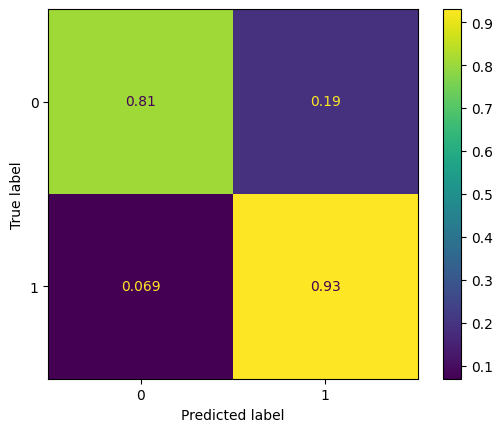

In [11]:
# your code here
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

classifier = LogisticRegression(class_weight="balanced")
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

conf_mat = confusion_matrix(y_test,predictions,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

precision = precision_score(y_test,predictions, average="macro")
print(precision)

## 6. Use the model to filter out badly segmented cells
Let's start by measuring the morphological features of the segmented cells.   
For that we will be using [`regionprops_table`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table) from `skimage.measure`.   

Then we will convert the table to a `pandas` dataframe.

```python
from skimage.measure import regionprops_table
measurements = regionprops_table(labels, properties=["property_1", "property_2", ...])
measurements = pd.DataFrame.from_dict(measurements)
```

The properties we want to measure are: `label`, `area`, `perimeter`, `axis_major_length`, `axis_minor_length`, `eccentricity`.

---

We can then need to rename them to match the dataset names:

```python
measurements = measurements.rename(columns={'old_name_1':'new_name_1', 'old_name_2':'old_name_2', ...})
```

---

And finally, we look at the table:
```python
measurements.head()
```

In [12]:
# your code here
from skimage.measure import regionprops_table

measurements = regionprops_table(labels, properties=['label', 'area', 'perimeter', 'axis_major_length', 'axis_minor_length', 'eccentricity'])
measurements = pd.DataFrame.from_dict(measurements)
measurements = measurements.rename(columns={'area':'Area', 'perimeter':'Perimeter', 'axis_major_length':'Length', 'axis_minor_length':'Width', 'eccentricity':'Eccentricity'})
measurements.head()

,label,Area,Perimeter,Length,Width,Eccentricity
0,1,261.0,60.284271,19.673022,17.114369,0.493156
1,2,14.0,12.207107,7.017299,2.646208,0.926173
2,3,17.0,14.828427,9.191363,2.423177,0.964622
3,4,289.0,61.112698,20.087097,18.347937,0.407021
4,5,260.0,58.041631,19.110599,17.397147,0.413861


Normalized the measurements as we did for the training data.   
However, we need to normalize it according to the mean and standard deviation of the training data.   
We can adapt the code from the `normalize_column` function we used before:
```python
def normalize_column_test(data_column, mean, std):
    # notice that now we pass the mean and std as arguments

    normalized_column = (data_column - mean) / std

    return normalized_column

normalized_measurements[col] = normalize_column_test(measurements[col], data[col].mean(), data[col].std())
```
Don't forget to store the normalized table in the variable `normalized_measurements`

In [13]:
# your code here
normalized_measurements = measurements.copy()
cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity']

def normalize_column_test(data_column, mean, std):
    # notice that now we pass the mean and std as arguments

    normalized_column = (data_column - mean) / std

    return normalized_column

for col in cols:
    normalized_measurements[col] = normalize_column_test(measurements[col], data[col].mean(), data[col].std())

We can now use our trained model to predict whether each cell is well or badly segmented.   
We do this by:   
1. Use the classifier to predict   

```python
predictions = classifier.predict(measurements[columns_list].to_numpy())
```

2. Create a copy of the labels image   

```python
filtered = labels.copy()
```

3. Loop through the labels column of regionprops_table and set the label to 0 if the prediction is 0   

```python
for index, label in enumerate(measurements['label']):
    if predictions[index] == 0:
        filtered[filtered == label] = 0 # sets all pixels where the value is equal to label to 0
```

4. Color the filtered_labels as we did for the original labels (hint: label2rgb)   

5. Display the cropped version (use indices [200:500, 200:600]) of both original and filtered labels using matplotlib

/Users/bsaraiva/mambaforge/envs/bioimagecourse/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

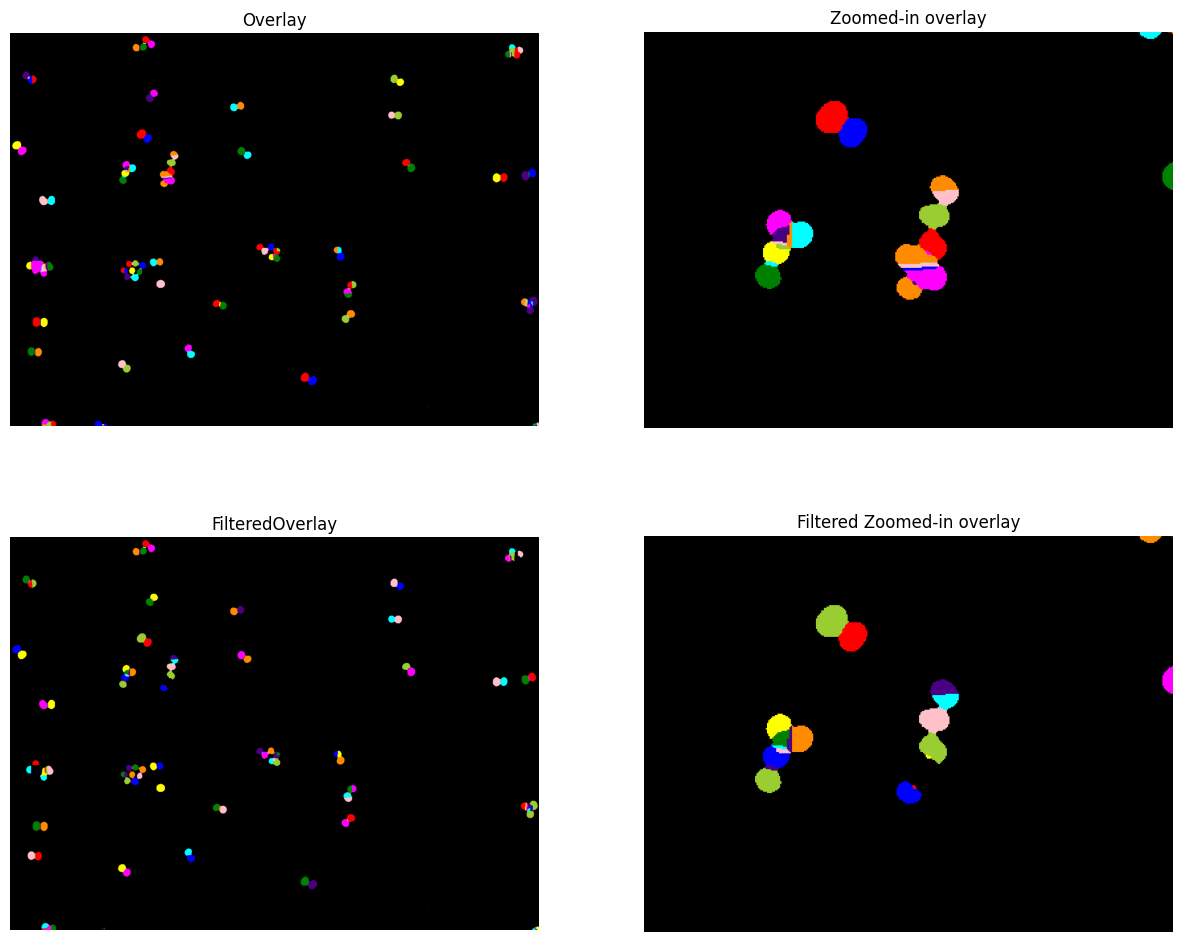

In [14]:
# your code here
preds = classifier.predict(normalized_measurements[columns_list].to_numpy())

filtered_labels = labels.copy()
for index, label in enumerate(measurements['label']):
    if preds[index] == 0:
        filtered_labels[labels == label] = 0

colored_filtered_labels = label2rgb(filtered_labels, bg_label=0)

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.title('Overlay')
plt.imshow(colored_labels, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Zoomed-in overlay")
plt.imshow(colored_labels[200:500, 200:600], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('FilteredOverlay')
plt.imshow(colored_filtered_labels, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Filtered Zoomed-in overlay")
plt.imshow(colored_filtered_labels[200:500, 200:600], cmap='gray')
plt.axis('off')

## 7. Exercise: Apply the same steps to the sle1 images

You can find them under `../data/images/` with names starting with `sle1_`

In [15]:
# your code here

## 8. Exercise: Try a different classifier

You can find a list of other scikit-learn models [here](https://scikit-learn.org/stable/supervised_learning.html).

In [16]:
# your code here